In [4]:
!pip install jax==0.3.25 jaxlib==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
  Preparing metadata (setup.py) ... done


In [5]:

#DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [6]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [7]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:7.6


In [8]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

In [9]:
from functools import partial


# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

In [25]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

In [11]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:12.8


In [21]:
!pip install ipywidgets
!pip install pillow

import ipywidgets as widgets
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont

orientation_dropdown = widgets.Dropdown(
    options=['landscape', 'portrait'],
    value='landscape',
    description='Orientation:'
)

text_input = widgets.Text(
    value='',
    description='Text:'
)

num_images_input = widgets.IntText(
    value=1,
    description='Number of Images:'
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00


Dropdown(description='Orientation:', options=('landscape', 'portrait'), value='landscape')

Text(value='sunset over a lake in the mountains', description='Text:')

IntText(value=1, description='Number of Images:')

Button(description='Generate Images', style=ButtonStyle())

['landscape image of sunset over a lake in the mountains']


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float16 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


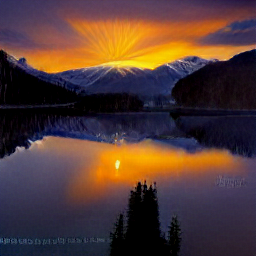

In [33]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange


def generate_images(button):

    orientation = orientation_dropdown.value
    text = text_input.value
    prompt=f"{orientation} image of {text}"
    prompts = []
    prompts.append(prompt)

    tokenized_prompts = processor(prompts)
    tokenized_prompt = replicate(tokenized_prompts)
    n_predictions = num_images_input.value

    # We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
    gen_top_k = None
    gen_top_p = None
    temperature = None
    cond_scale = 10.0

    # generate images
    images = []
    seed = random.randint(0, 2**32 - 1)
    key = jax.random.PRNGKey(seed)
    for i in trange(max(n_predictions // jax.device_count(), 1)):

      key, subkey = jax.random.split(key)

      encoded_images = p_generate(
          tokenized_prompt,
          shard_prng_key(subkey),
          params,
          gen_top_k,
          gen_top_p,
          temperature,
          cond_scale,
      )

      encoded_images = encoded_images.sequences[..., 1:]
      # decode images
      decoded_images = p_decode(encoded_images, vqgan_params)
      decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
      for decoded_img in decoded_images:
          img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
          images.append(img)
          display(img)
          print()


generate_button = widgets.Button(description='Generate Images')

generate_button.on_click(generate_images)


display(orientation_dropdown)
display(text_input)
display(num_images_input)
display(generate_button)
